## *Using neural networks to recognize clothing items from their images*
 
 
In this tutorial, we will learn how to use the [Keras](https://keras.io/) and [Tensorflow](https://www.tensorflow.org/) libraries to create a neural network that classifies various images from the [Fashion MNIST Dataset](https://research.zalando.com/welcome/mission/research-projects/fashion-mnist/) into different types of clothing items. 

This tutorial uses Python, some familiarity with programming would be beneficial but is not required. Run each code cell in order by hitting "Shift + Enter", or clicking the "Run" button in the menu bar above this notebook. Feel free to modify the code to familiarize yourself with how the code works.


**Outline:**

1. Import libraries
2. Getting data
3. Explore and preprocess the data
4. Build and train a neural network to model the data
5. Evaluate model accuracy
6. Make some predictions
7. Visualize results

**Get started:** Hit "Shift-Enter" on the code cells to run! 

### Step 1. Import libraries

We first import the relevant libraries. This includes Tensorflow and [Keras](https://www.tensorflow.org/guide/keras) to build and train neural networks, [Numpy](https://docs.scipy.org/doc/numpy-1.15.1/user/index.html) to process the data, and pyplot from [Matplotlib](https://matplotlib.org/) for plotting. We will also use the [Gzip](https://docs.python.org/3/library/gzip.html) and os libraries to handle zipped (compressed) files and to place the extracted data in the correct directories. The [subprocess](https://docs.python.org/2/library/subprocess.html) library allows us to call Unix shell commands from a Python script, and will be used to get the data from an online server directly

In [1]:
import numpy as np

import tensorflow as tf
from tensorflow import keras
from subprocess import call

import matplotlib.pyplot as plt
import gzip
import os

The cell below sets the random seed to ensure consistent results every time the notebook is run, an important step in reproducibility

In [2]:
np.random.seed(0)
tf.random.set_seed(0)

### Step 2. Getting data


The Fashion MNIST database contains 70,000 grayscale images of 10 different categories of clothing items. The images show individual articles of clothing at low resolution (28 by 28 pixels). We will use 60,000 images to train the network and 10,000 images to evaluate how accurately the network learned to classify images.

For more information on the dataset, click [here](https://research.zalando.com/welcome/mission/research-projects/fashion-mnist/).

Testing and training datasets are located as compressed in gzip files [here](https://storage.googleapis.com/tensorflow/tf-keras-datasets/t10k-images-idx3-ubyte.gz). To download the data from this location, we define two helper functions. The first is `load_data()`, which uses the subprocess library to call the `wget` Unix command that downloads data from an online location to a specified directory on our system. This directory is specificed using the os library. The second function `extract_data()`, takes the data from the gzip and formats it into a (60,000 x 28 x 28 x 1) array of 8 byte, unsigned integers. In this notation, 60,000 is the number of training images, 28 is the height and width of each image (in pixels), and 1 is the number of "channels" in the image. For a grayscale image, the number of "channels" is 1, a colored image would have 3 "channels" (RGB).

Labels for each image are defined as a number from 0 to 9, each corresponding to a class of clothing items, these class labels are defined in a list.

Label | Class
--- | --- 
0 | Tshirt/top
1 | Trouser
2 | Pullover
3 | Dress
4 | Coat
5 | Sandal
6 | Shirt
7 | Sneaker
8 | Bag
9 | Ankle Boot

In [3]:
def extract_data(filename, num_data, head_size, data_size): # This function loads and parses the data
    with gzip.open(filename) as bytestream:
        bytestream.read(head_size)
        buf = bytestream.read(data_size * num_data)
        data = np.frombuffer(buf, dtype=np.uint8)
    return data

def load_data():
    call("wget -nc https://storage.googleapis.com/tensorflow/tf-keras-datasets/t10k-images-idx3-ubyte.gz  -o " \
         + os.getcwd() + "t10k-images-idx3-ubyte.gz", shell=True)
    call("wget -nc https://storage.googleapis.com/tensorflow/tf-keras-datasets/train-images-idx3-ubyte.gz -o " \
         + os.getcwd() + "train-images-idx3-ubyte.gz", shell=True)
    call("wget -nc https://storage.googleapis.com/tensorflow/tf-keras-datasets/train-labels-idx1-ubyte.gz -o " \
         + os.getcwd() + "train-labels-idx1-ubyte.gz", shell=True)
    call("wget -nc https://storage.googleapis.com/tensorflow/tf-keras-datasets/t10k-labels-idx1-ubyte.gz -o " \
         + os.getcwd() + "t10k-labels-idx1-ubyte.gz", shell=True)

    train_images = extract_data(os.getcwd() + '/train-images-idx3-ubyte.gz', 60000, 16, 28*28)
    test_images = extract_data(os.getcwd()  + '/t10k-images-idx3-ubyte.gz', 10000, 16, 28*28)
    
    train_labels = extract_data(os.getcwd() + '/train-labels-idx1-ubyte.gz', 60000, 8, 1)
    test_labels = extract_data(os.getcwd()  + '/t10k-labels-idx1-ubyte.gz', 10000, 8, 1)
    
    train_images = train_images.reshape((60000, 28, 28, 1))
    test_images = test_images.reshape((10000, 28, 28, 1))
    
    train_labels = train_labels.reshape((60000, 1))
    test_labels = test_labels.reshape((10000, 1))
    
    return train_images, test_images, train_labels, test_labels

In [4]:
train_images, test_images, train_labels, test_labels = load_data()

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 
               'Shirt', 'Sneaker', 'Bag', 'Ankle boot'] # Label Classes

### Step 3. Explore and preprocess the data

To ensure that data was loaded correctly, we will now look at a sample image from the training set.

- You can modify the variable **"index"** in the following code to get any image in the training set
- You can print the shapes of all arrays being used to check whether the data was loaded correctly

Train Images Array shape: (60000, 28, 28, 1)
Train Labels Array shape: (60000, 1)
Test Images Array shape: (10000, 28, 28, 1)
Test Labels Array shape: (10000, 1)


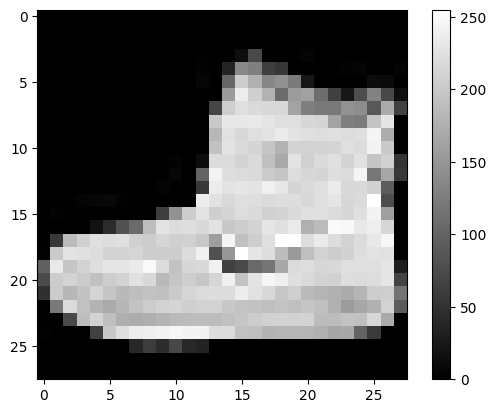

In [5]:
plt.figure()
index = 0 #index runs from 0 to 59999
plt.imshow(train_images[index][:, :, 0], cmap='gray') # By altering 'index' you will see another of the pictures imported
plt.colorbar()
plt.grid(False)

print("Train Images Array shape:", train_images.shape)
print("Train Labels Array shape:", train_labels.shape)
print("Test Images Array shape:", test_images.shape)
print("Test Labels Array shape:", test_labels.shape)

We will now scale the data to range between 0 and 1 before feeding it to the neural network model. It's important that the training set and the testing set are preprocessed in the same way and we thus divide the training and testing data by 255 (the maximum value that can be possibly achieved). Click [here](https://en.wikipedia.org/wiki/Feature_scaling) to learn about other types for feature (input) scaling.

After this, we display the first 25 images from the dataset to visualize the variety of images in our dataset

In [6]:
train_images = train_images/255.0
test_images = test_images/255.0

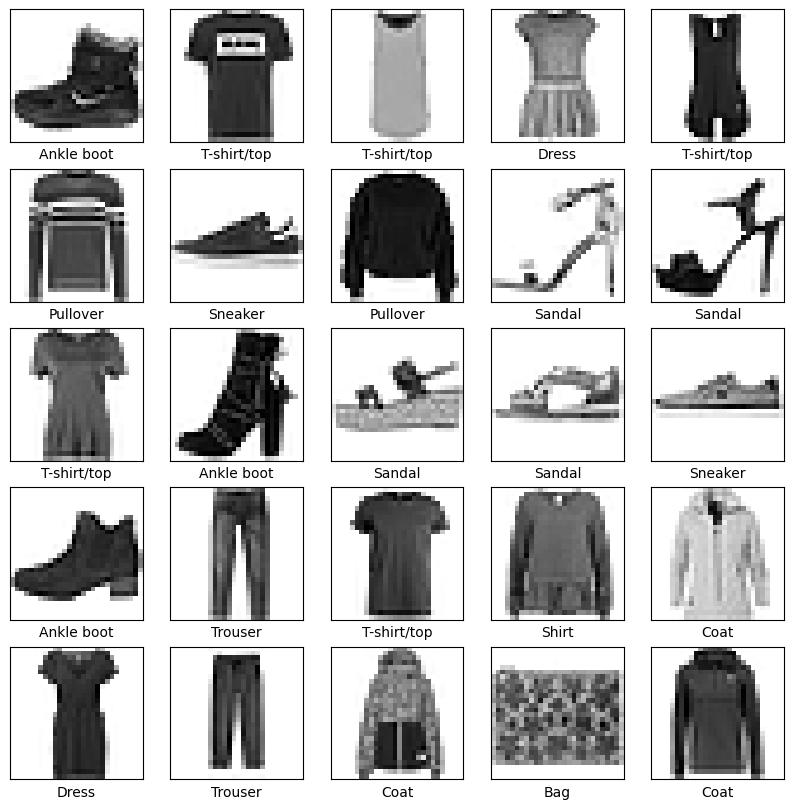

In [7]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i][:, :, 0], cmap=plt.cm.binary)
    plt.xlabel(class_names[int(train_labels[i])])

### Step 4. Build and train neural network to model the data

Building the neural network requires configuring the layers of the model, then compiling the model. We use the Sequential class to quickly add layers to our model.

In this instance, we will be using `Conv2D` and `Pool` layers to build our model. `Conv2D` layers are layers that represent convolution operations on an input array. These convolution operations use "filters" to learn the features in the images. These "filters" are small matrices (often 2x2 or 3x3) whose entries are learnt by the model during training. These values are optimized such that the network learns image features across multiple `Conv2D` layers. `Pool` layers "pool" or gather information from a set of pixels into one pixel. To learn more about `Conv2D` layers and the underlying operations, click [here](https://stanford.edu/~shervine/teaching/cs-230/cheatsheet-convolutional-neural-networks).

After multiple convolution and pooling operations, we will use a `Flatten` layer to flatten the image into a long vector of numbers. Finally, we will use a `Dense` layer to predict the output of the network, which will be a set of 10 numbers that each define the probability of the current image being of that image class.

The convolutional layers use a [ReLU](https://en.wikipedia.org/wiki/Rectifier_(neural_networks) (Rectified Linear Unit) [activation function](https://en.wikipedia.org/wiki/Activation_function), which can be seen as a "ramp" function in which only the positive part of the input passes through.

The output layer layer uses a **SoftMax** (Normalized Exponential Function) activation, in which inputs are mapped into real values such that each value is between 0 and 1 and the sum of all values equals one. This helps us interpret these outputs as probabilities, and further distill them as predicted classes

Click [here](https://towardsdatascience.com/secret-sauce-behind-the-beauty-of-deep-learning-beginners-guide-to-activation-functions-a8e23a57d046) to see and visualize the equations describing these activation functions.

In [8]:
model = keras.Sequential()
model.add(keras.Input(shape=(28, 28, 1)))
model.add(keras.layers.Conv2D(8, 3, activation='relu', padding='same', input_shape=(28, 28, 1)))
model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))
model.add(keras.layers.Conv2D(16, 3, activation='relu', padding='same'))
model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(10, activation='softmax'))

In [9]:
model.summary() #Summary helps view the layers in the model, and the number of parameters in each layer

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 8)         80        
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 8)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 16)        1168      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 16)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 10)                7

Before the model is ready for training, it needs a few more settings. These are added during the model's compile step:

- *Loss function:* This measures how accurate the model is during training. We want to minimize this function to "steer" the model in the right direction.
- *Optimizer:* This decides the optimization technique used to achieve a minimum for the loss function
- *Metrics:* Used to monitor the training and testing steps. The following example uses *accuracy*, the fraction of the images that are correctly classified.
- *Epochs:* These epochs represent the number of times the model will run through the training set, and affects how well the optimizer can converge to the best possible weights. Click [here](https://towardsdatascience.com/epoch-vs-iterations-vs-batch-size-4dfb9c7ce9c9) to learn more about iterations, epochs and batch sizes

In [10]:
optimizer = keras.optimizers.Adam(learning_rate=1e-3) # Initialize an Adam optimizer with a learning rate of 0.001
#Compile the model with the Adam optimizer and Categorical Cross Entropy loss
model.compile(optimizer=optimizer, loss=keras.losses.SparseCategoricalCrossentropy(), metrics=['sparse_categorical_crossentropy'])
EPOCHS = 100 #Epoch

We are now ready to train the model. The `model.fit()` function takes in the Numpy data we obtained earlier. This function automatically handles backpropogation and updating model weights.

To learn more about backpropagation and how neural networks learn, you can click [here](https://www.youtube.com/watch?v=aircAruvnKk) or [here](https://www.youtube.com/watch?v=Ilg3gGewQ5U).

In [11]:
history = model.fit(train_images, train_labels, epochs=3)

Epoch 1/3
1875/1875 [==============================] - 22s 11ms/step - loss: 0.5174 - sparse_categorical_crossentropy: 0.5174
Epoch 2/3
1875/1875 [==============================] - 20s 11ms/step - loss: 0.3580 - sparse_categorical_crossentropy: 0.3580
Epoch 3/3
1875/1875 [==============================] - 21s 11ms/step - loss: 0.3203 - sparse_categorical_crossentropy: 0.3203


At this point, we can check some of the [weights](https://en.wikipedia.org/wiki/Synaptic_weight) from the trained neural network. These weights, in a way, represent the relationship between inputs and outputs.

In [12]:
weights = model.get_weights()
weights[3]

array([ 0.11109082,  0.07285059,  0.16619137, -0.04293008, -0.08386151,
        0.20252956,  0.0808741 ,  0.0326075 , -0.04940938, -0.02229171,
        0.01736309, -0.13329811,  0.00512093, -0.04258244, -0.06840573,
       -0.07439872], dtype=float32)

### Step 5. Evaluate model training

We use pyplot from [Matplotlib](https://matplotlib.org/) to plot the Learning Curve, which in the case of neural nets show shows the evolution of training and validation loss over epochs. In this simple example, our metric of accuracy is "Sparse Categorical Crossentropy." Entropy in this context is a kind of information. It reflects ambiguity in a model by showing how much choice is permitted by the explanatory function. if there is Zero entropy, the model fully explains the features, so there is only one choice. if there is One entropy there are two equally viable choices. The entropy curve is logarithmic in nature.

Here we only have a training set and no validation set. If we had used a validation set, we could have checked for overfitting by monitoring if validation crossentropy starts to raise while training entropy continues to fall. However, Keras, makes protecting against overfitting easy by exposing the `EarlyStopping()` functionality, click [here](https://keras.io/api/callbacks/early_stopping/) to learn more.

In [13]:
training_accuracy = history.history['sparse_categorical_crossentropy']

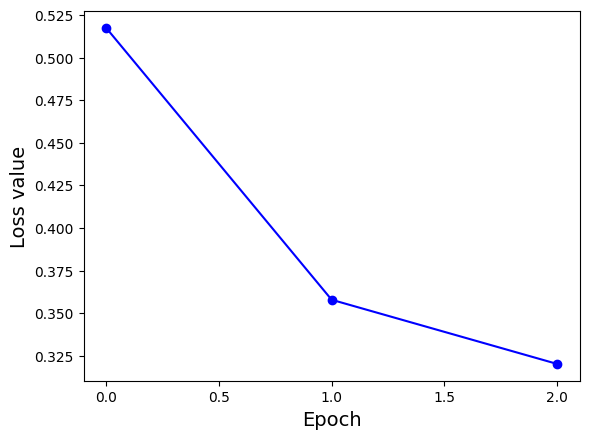

In [14]:
plt.plot(training_accuracy, 'bo-')
plt.xlabel('Epoch', c='k', fontsize=14)
plt.ylabel("Loss value", c='k', fontsize=14)
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)

At this stage, if we are satisfied with the model training, we can check the accuracy of our model on our data. To do this, we will call the model.evaluate() function on the trainImages and trainLabels arrays. Accuracy can usually be improved by changing parameters in the building of the model, by running the training for more epochs and by feeding the model more instances of the training set (more images).

In [15]:
train_loss, train_acc = model.evaluate(train_images, train_labels)
test_loss, test_acc = model.evaluate(test_images, test_labels)

print('Train accuracy:', train_acc)
print('Test accuracy:', test_acc)

313/313 [==============================] - 2s 5ms/step - loss: 0.3377 - sparse_categorical_crossentropy: 0.3377
Train accuracy: 0.3053833544254303
Test accuracy: 0.3376518189907074


In a read-write filesystem we could, being satisfied at this point, save the model into an h5 format training by using the `model.save()` function. This saved model can be reloaded using the `load_model()` function

`model.save('./Models/classification_model.h5')`

`model = keras.models.load_model('./Models/classification_model.h5')`

### Step 6. Make some predictions

After these steps, we are ready to make predictions. This predictions represent the certainty the model has of each element belonging to a particular class.

Predictions are made by calling the `model.predict()` function. The model will give a prediction for each of the elements on the testImages array.

By calling `predictions[0]` we are accesing the array we created to store the model's predictions for element 0, the first image. We see that the model gives the maximum value of certainty to the category (label) \#9, meaning that the model believes this image is an "ankle boot".

In [16]:
predictions = model.predict(test_images)
predictions[0]

313/313 [==============================] - 1s 4ms/step


array([3.6474848e-06, 2.9811634e-08, 5.0570083e-08, 9.0086289e-08,
       1.0058093e-08, 1.3627232e-02, 3.3757080e-06, 4.9478628e-02,
       8.4162765e-04, 9.3604529e-01], dtype=float32)

### Step 7. Visualize results

To visualize the predictions, we use two helper functions. The first function, `plot_image()`, generates an image from the set and presents the model's results in a color-coded fashion, displaying the prediction in RED if the prediction does not match the image and displaying the prediction in BLUE otherwise. The second function, `plot_value_array()` generates a bar chart representing the certainty of each of the classes for each element. This is also color-coded.

In [ ]:
def plot_image(i, predictions_array, true_label, img):
    prediction, gt_label, curr_img = predictions_array[i], true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
  
    plt.imshow(curr_img[:, :, 0], cmap='gray')
    predicted_label = np.argmax(prediction)
    if predicted_label == gt_label:
        color = 'blue'
    else:
        color = 'red'
  
    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label], 100*np.max(prediction), 
                                         class_names[int(gt_label)]), color=color)

def plot_value_array(i, predictions_array, true_label):
    prediction, gt_label = predictions_array[i], true_label[i]
    plt.grid(False)
    plt.xticks(np.arange(10))
    plt.ylim([0, 1])
    plt.yticks([])
    thisplot = plt.bar(range(10), prediction, color="#777777")
    predicted_label = np.argmax(prediction)
    
    thisplot[int(predicted_label)].set_color('red')
    thisplot[int(gt_label)].set_color('blue')

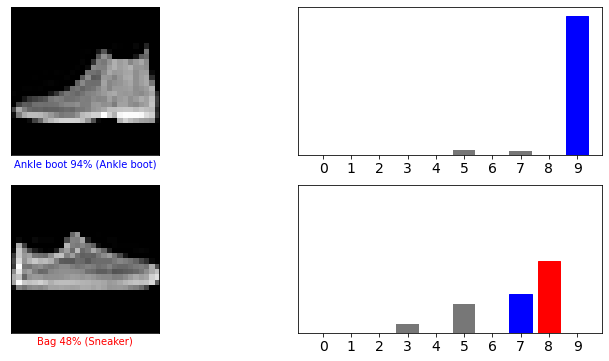

In [ ]:
i = 0
plt.figure(figsize=(12,6))
plt.subplot(2,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(2,2,2)
plot_value_array(i, predictions,  test_labels)
i = 12
plt.subplot(2,2,3)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(2,2,4)
plot_value_array(i, predictions,  test_labels)